## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
import embodied as emg
import embodied_indep as emi
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate


importlib.reload(MGME) 
importlib.reload(emg)
importlib.reload(emi)


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'
#tensorboard --logdir=mingame_worker_1:'<...>'

## Setup k-vs-(N-k) Mingame Env

In [3]:
importlib.reload(MGME)

<module 'minoritygame.minority_multienv' from '/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/minoritygame/minority_multienv.py'>

In [4]:
# n_agents = 61
# exos = (np.random.sample(n_agents) < 0.3)  # np.sum(exos)

exos = [True, True, False, False, False]
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

5 2 [0, 1]
3 1


In [5]:
len(menv.actor_exoQ), (len(menv.agents), menv.nagents)

(5, (5, 5))

## Setup MARL

In [6]:
num_episodes, n_epochs, max_len = (100, 751, 150)

In [7]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,), out_dim=out_dim, gamma_reg=5.)

In [8]:
tf.reset_default_graph()
importlib.reload(emi)

<module 'embodied_indep' from './embodied_arch/embodied_indep.py'>

In [9]:
## REINFORCE with Baseline
# embrf = emi.EmbodiedAgent_IRFB(
#     name="mgRFB_k-vs-N-k",
#     env_=menv, latentDim=4, 
#     alpha_p=5.e-1, alpha_v=1e-2, 
#     actorNN=actor, valueNN=value,
#     sensorium=sensor,
#     max_episode_length=max_len
# )

In [10]:
## Actor-Critic
embrf = emi.EmbodiedAgent_IAC(
    name="mgAC_k-vs-N-k",
    env_=menv, latentDim=4, 
    alpha_p=50, alpha_v=12., 
    actorNN=actor, valueNN=value,
    sensorium=sensor,
    _every_=150,
    max_episode_length=max_len
)

print(embrf, embrf.s_size, embrf.a_size)

<embodied_indep.EmbodiedAgent_IAC object at 0x1c3addedd0> 3 1


In [11]:
sess = tf.InteractiveSession()
embrf.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgAC_k-vs-N-k


In [12]:
## Verify step + play set up
state = embrf.env.reset()
# print(state, embrf.act(state, sess))

embrf.play(sess)
np.sum(np.array(embrf.episode_buffer['rewards']), axis=0)
# np.array(embrf.episode_buffer['rewards'])

array([47., 37.])

In [13]:
print(embrf.last_total_returns)
print(emi.summarize_np(embrf.last_total_returns))

[47. 37.]
(37.0, 42.0, 47.0)


### Pre-test Agent

In [14]:
print('Baselining untrained pnet...')
rwd_mg0 = []
for k in range(num_episodes):
    embrf.play(sess, terminal_reward=0.)
    rwd_mg0.append(embrf.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf_mg = 100.*np.mean(np.array(rwd_mg0)/float(embrf.max_episode_length), axis=0)
print("\nAgents win an average of {} pct".format(base_perf_mg))

base_per_agent = 100.*np.mean(np.array(rwd_mg0)/float(embrf.max_episode_length), axis=0)

Baselining untrained pnet...
Episode 80/100
Agents win an average of [28.85333333 28.08      ] pct


## Train MARL Agents

	Iteration 299: Value loss([1.09657812 2.19429731])
 [1.521742   2.65006264]


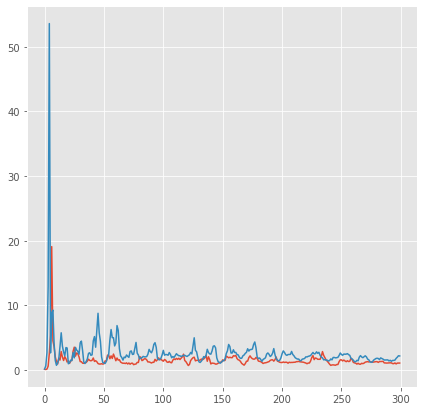

In [15]:
obs = []
for ct in range(300):
    embrf.play(sess)
    tmp = embrf.pretrainCritics(sess)
    obs.append(tmp)
    print('\r\tIteration {}: Value loss({})'.format(ct, tmp), end="")
plt.plot(obs)

# plt.figure()
# sns.violinplot(np.array(obs).ravel())
print('\n', np.mean(obs, axis=0))

In [16]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = embrf.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent mgAC_k-vs-N-k
Epoch no.: 0/751

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (51.0, 60.0, 69.0)
Losses/Policy LLs: (-1.1783004, -0.6361924, -0.3678824)
Losses/Critic Scores: (17.574389, 21.337336, 25.24463)
Losses/Policy Entropies: (0.6173302, 0.6440768, 0.67084193)
Saved Model
Epoch no.: 150/751

	Stats @Step 150: 	(Min, Mean, Max)
Perf/Recent Rewards: (53.0, 71.5, 90.0)
Losses/Policy LLs: (-3.8203735, -0.10745056, -0.022163413)
Losses/Critic Scores: (16.832155, 27.564924, 38.314938)
Losses/Policy Entropies: (0.105418704, 0.13654962, 0.18032011)
Saved Model
Epoch no.: 300/751

	Stats @Step 300: 	(Min, Mean, Max)
Perf/Recent Rewards: (43.0, 75.0, 107.0)
Losses/Policy LLs: (-0.008608993, -0.0050156084, -0.0012994071)
Losses/Critic Scores: (16.73719, 27.723295, 38.724003)
Losses/Policy Entropies: (0.01, 0.030041398, 0.049331676)
Saved Model
Epoch no.: 450/751

	Stats @Step 450: 	(Min, Mean, Max)
Perf/Recent Rewards: (43.0, 75.0, 107.0)
Losses/Policy L

### Post-test Agent

In [17]:
# Test pnet!
print('Testing...')
rwd_mg = []
for k in range(num_episodes):
    embrf.play(sess, terminal_reward=0.)
    rwd_mg.append(embrf.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf_mg = 100.*np.mean(np.array(rwd_mg)/float(embrf.max_episode_length), axis=0)
print("\nAgent wins an average of {} pct compared to baseline of {} pct".format(
    trained_perf_mg, base_perf_mg) )

trained_per_agent = 100.*np.mean(np.array(rwd_mg)/float(embrf.max_episode_length), axis=0)

Testing...
Episode 80/100
Agent wins an average of [29.31333333 70.68      ] pct compared to baseline of [28.85333333 28.08      ] pct



Agent wins an average of [29.31333333 70.68      ] pct 
compared to baseline of [28.85333333 28.08      ] pct


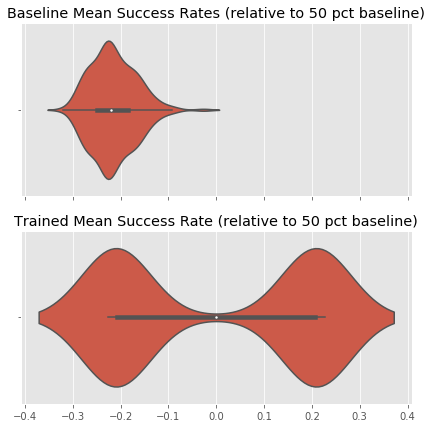

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(np.array(rwd_mg0)/embrf.max_episode_length - 0.5, ax = axs[0])
axs[0].set_title('Baseline Mean Success Rates (relative to 50 pct baseline)')
sns.violinplot(np.array(rwd_mg)/embrf.max_episode_length - 0.5, ax = axs[1])
axs[1].set_title('Trained Mean Success Rate (relative to 50 pct baseline)')

print("\nAgent wins an average of {} pct \ncompared to baseline of {} pct".format(
    trained_perf_mg, base_perf_mg) )

Text(0.5, 0, 'Agent Index')

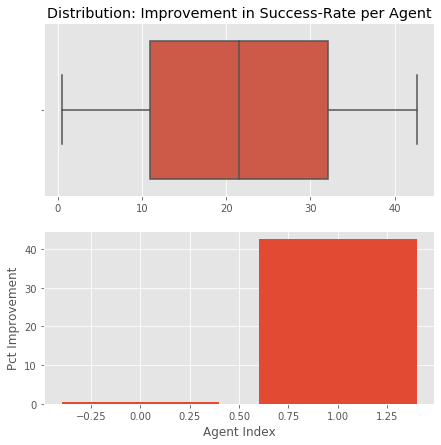

In [19]:
fig, axs = plt.subplots(2,1)
cmp = sns.boxplot(trained_per_agent-base_per_agent, ax = axs[0])
axs[0].set_title('Distribution: Improvement in Success-Rate per Agent');
axs[1].bar(x=range(sum(exos)), height=(trained_per_agent-base_per_agent))
axs[1].set_ylabel('Pct Improvement')
axs[1].set_xlabel('Agent Index')